# Détection vidéo du port du masque

In [15]:
from imutils.video import VideoStream
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import cv2
import simpleaudio as sa

### Import des modèles de détection du visage et du masque

In [2]:
#import du modèle entraîné dnas le notebook précédent
detec_masque_model = load_model("model_s")

In [3]:
#import du CascadeClassifier de Viola & Davis
detec_visage_model = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

### Détection du visage - test avec une image

In [4]:
imgtest = cv2.imread("Dataset_masks/train/without_mask/11.jpg",3)
graytest = cv2.cvtColor(imgtest, cv2.COLOR_BGR2GRAY)

In [5]:
visage = detec_visage_model.detectMultiScale(graytest, 1.3, 5)

for (x,y,w,h) in visage:
    imgtest = cv2.rectangle(imgtest,(x,y),(x+w,y+h),(255,0,0),2)
    roi_gray = graytest[y:y+h, x:x+w]
    roi_color = imgtest[y:y+h, x:x+w]

(480, 852, 3)


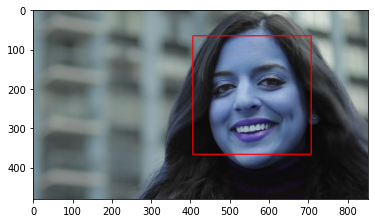

In [6]:
print(imgtest.shape)
plt.imshow(imgtest) 

### Détection du visage dans une video

In [7]:
def detection_visage(mirror=False):
    cam = cv2.VideoCapture(0)
    while True:
        ret_val, frame = cam.read()
        grayframe = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        visage = detec_visage_model.detectMultiScale(grayframe, 1.3, 5)

        for (x,y,w,h) in visage:
            frame = cv2.rectangle(frame,(x,y),(x+w,y+h),(0,0,255),2)
            roi_gray = grayframe[y:y+h, x:x+w]
            roi_color = frame[y:y+h, x:x+w]
            
        if mirror: 
            frame = cv2.flip(frame, 1)
        cv2.imshow('my webcam', frame)
        if cv2.waitKey(1) == 27: 
            break  # esc to quit
    cam.release()
    cv2.destroyAllWindows()

In [8]:
detection_visage(mirror=True)

### Ajout de la détection du port du masque

In [16]:
#chargement des images et du son à afficher/jouer en réaction à la prédiction du modèle

content = cv2.imread('images/happy1.png')

pas_content = cv2.imread('images/sad1.png')

wave_obj = sa.WaveObject.from_wave_file("./toon.wav")

In [17]:
def detection_masque(mirror=False):
    cam = cv2.VideoCapture(0)
    while True:
        ret_val, frame = cam.read()
        grayframe = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        visage = detec_visage_model.detectMultiScale(grayframe, 1.3, 5)
        
        # on traite l'image vidéo pour qu'elle corresponde aux données d'entrée du modèle,
        # puis on fait la prédiction        
        frame100 = cv2.resize(frame, (100,100))
        frame100 = (frame100.astype('float') / 255).reshape(1,100,100,3)
        prediction = detec_masque_model.predict(frame100)
        
        # creation d'une ROI pour l'affichage du smiley
        rows,cols,channels = pas_content.shape
        roi_smiley = frame[0:rows, 0:cols]
        
        # Selon le résultat de la prédiction, on affiche un carré rouge (pas de masque)
        # ou un carré vert (masque en place)
        if prediction > 0.5:
            for (x,y,w,h) in visage:
                frame = cv2.rectangle(frame,(x,y),(x+w,y+h),(0,255,0),2)
                roi_gray = grayframe[y:y+h, x:x+w]
                roi_color = frame[y:y+h, x:x+w]
                frame[0:rows, 0:cols ] = content # affiche le smiley content
                
        else:
            for (x,y,w,h) in visage:
                frame = cv2.rectangle(frame,(x,y),(x+w,y+h),(0,0,255),2)
                roi_gray = grayframe[y:y+h, x:x+w]
                roi_color = frame[y:y+h, x:x+w]
                frame[0:rows, 0:cols ] = pas_content # affiche le smiley triste
                play_obj = wave_obj.play() # joue le son d'alerte
            
        if mirror: # retourne l'image pour l'afficher en miroir
            frame = cv2.flip(frame, 1)
        
        # affichage de l'image
        cv2.imshow('my webcam', frame)
        
        # pour quitter, appui sur la touche ESC
        if cv2.waitKey(1) == 27: 
            break 
    cam.release()
    cv2.destroyAllWindows()

In [18]:
detection_masque(mirror=True)

<hr>

### Avec l'enregistrement de la vidéo

In [23]:
def detection_masque_enrg(mirror=False):
    cam = cv2.VideoCapture(0)
    
    # on définit le codec et on crée un objet VideoWriter
    fourcc = cv2.VideoWriter_fourcc(*'MP4V')
    out = cv2.VideoWriter('output.mp4',fourcc, 20.0, (640,480))
    
    while True:
        ret_val, frame = cam.read()
        grayframe = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        visage = detec_visage_model.detectMultiScale(grayframe, 1.3, 5)
        
        # on traite l'image vidéo pour qu'elle corresponde aux données d'entrée du modèle,
        # puis on fait la prédiction        
        frame100 = cv2.resize(frame, (100,100))
        frame100 = (frame100.astype('float') / 255).reshape(1,100,100,3)
        prediction = detec_masque_model.predict(frame100)
        
        # creation d'une ROI pour l'affichage du smiley
        rows,cols,channels = pas_content.shape
        roi_smiley = frame[0:rows, 0:cols]
        
        # Selon le résultat de la prédiction, on affiche un carré rouge (pas de masque)
        # ou un carré vert (masque en place)
        if prediction > 0.5:
            for (x,y,w,h) in visage:
                frame = cv2.rectangle(frame,(x,y),(x+w,y+h),(0,255,0),2)
                roi_gray = grayframe[y:y+h, x:x+w]
                roi_color = frame[y:y+h, x:x+w]
                frame[0:rows, 0:cols ] = content
        else:
            for (x,y,w,h) in visage:
                frame = cv2.rectangle(frame,(x,y),(x+w,y+h),(0,0,255),2)
                roi_gray = grayframe[y:y+h, x:x+w]
                roi_color = frame[y:y+h, x:x+w]
                frame[0:rows, 0:cols ] = pas_content
            
        if mirror: # retourne l'image pour l'afficher en miroir
            frame = cv2.flip(frame, 1)
        
        out.write(frame)
        
        # affichage de l'image
        cv2.imshow('my webcam', frame)
        cv2
        
        # pour quitter, appui sur la touche ESC
        if cv2.waitKey(1) == 27: 
            break 
    out.release()
    cam.release()
    cv2.destroyAllWindows()

In [24]:
detection_masque_enrg(mirror=True)